--- Logistic Regression Model Results ---
Confusion Matrix:
 [[2 0]
 [0 1]]

Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         2
           1       1.00      1.00      1.00         1

    accuracy                           1.00         3
   macro avg       1.00      1.00      1.00         3
weighted avg       1.00      1.00      1.00         3



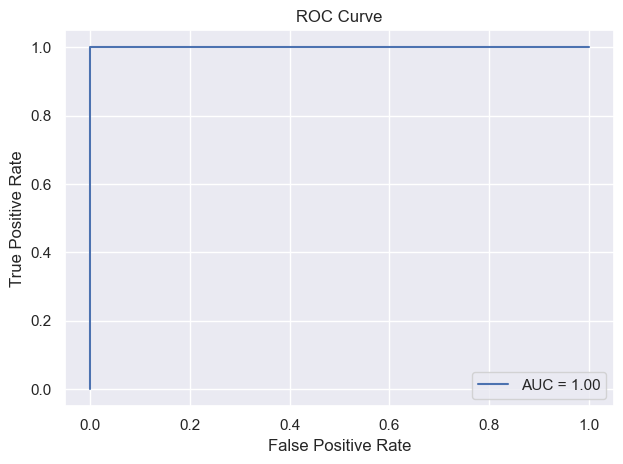

--- Isolation Forest Results ---


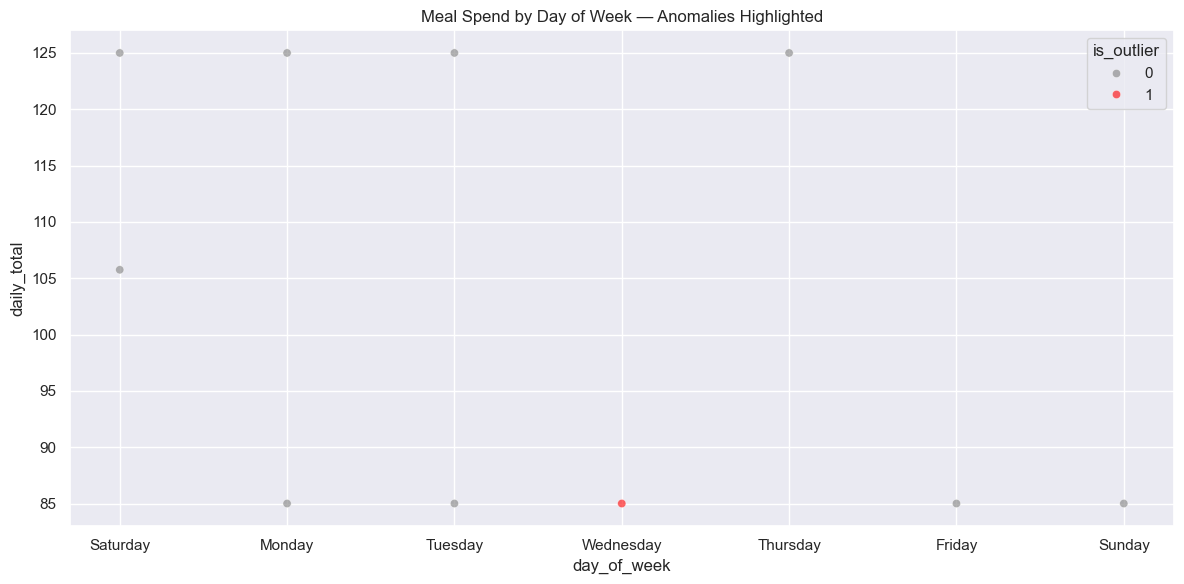

✔️ Exported logistic regression predictions to 'logistic_risk_predictions.csv'
✔️ Exported anomaly detection results to 'isolation_forest_anomalies.csv'
✔️ Exported daily meal totals to 'daily_meal_totals.csv'


In [3]:
# ########################### Per Diem Overspend Detection & Analysis ###########################
# Author: [Mike Ziemba]  |  Last Updated: [7 May 2025]  |  Project: P-Card Meals Per Diem Analysis

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
from sklearn.ensemble import IsolationForest
from sklearn.pipeline import make_pipeline
from sklearn.compose import ColumnTransformer

# ----------------------------
# Constants
# ----------------------------
PER_DIEM = 100
YEARS = [2023, 2024, 2025]

# ----------------------------
# Input Files
# ----------------------------
TRANSACTIONS_CSV = "dummy_pcard_transactions.csv"
CARDHOLDER_LIMITS_CSV = "dummy_pcardholder_limits.csv"
EMPLOYEE_LIST_CSV = "dummy_employee_list.csv"

# ----------------------------
# Load and Prepare Data
# ----------------------------
def load_data():
    txns = pd.read_csv(TRANSACTIONS_CSV, low_memory=False)
    cards = pd.read_csv(CARDHOLDER_LIMITS_CSV)
    emps = pd.read_csv(EMPLOYEE_LIST_CSV)

    # Standardize employee_id
    for df in [txns, cards, emps]:
        id_col = 'Employee - ID' if 'Employee - ID' in df.columns else 'employee_id'
        df[id_col] = df[id_col].astype(str).str.strip().str.replace('.0', '', regex=False)

    # Rename fields in employees
    emps = emps.rename(columns={
        'Employee - ID': 'employee_id',
        'Last Name': 'last_name',
        'First Name': 'first_name',
        'Job Title': 'job_title',
        'Company': 'company',
        'Employee Status': 'employee_status'
    })

    txns['transaction_date'] = pd.to_datetime(txns['transaction_date'], errors='coerce')
    txns['transaction_amount'] = pd.to_numeric(txns['transaction_amount'], errors='coerce')

    return txns, cards, emps

# ----------------------------
# Daily Totals & Per Cardholder Summary
# ----------------------------
def prepare_daily_summary(txns, cards, emps):
    meals_df = txns[txns['supplier_merchant_category_group_description'] == 'Eating And Drinking Places'].copy()
    meals_df = meals_df.merge(cards[['employee_id']], on='employee_id', how='inner')
    meals_df = meals_df.merge(emps, on='employee_id', how='left')

    daily = meals_df.groupby(['employee_id', 'transaction_date']).agg(
        daily_total=('transaction_amount', 'sum')
    ).reset_index()
    daily['over_per_diem'] = (daily['daily_total'] > PER_DIEM).astype(int)
    return meals_df, daily

# ----------------------------
# Logistic Regression Model
# ----------------------------
def run_logistic_model(daily, emps):
    company_lookup = emps[['employee_id', 'company']].drop_duplicates()
    daily = daily.merge(company_lookup, on='employee_id', how='left')
    daily['year_month'] = daily['transaction_date'].dt.to_period('M')

    monthly = daily.groupby(['employee_id', 'year_month']).agg(
        total_meal_days=('transaction_date', 'count'),
        days_over_limit=('over_per_diem', 'sum'),
        avg_daily_meal_total=('daily_total', 'mean'),
        max_daily_meal_total=('daily_total', 'max'),
        company=('company', 'first')
    ).reset_index()

    monthly['pct_days_over_limit'] = monthly['days_over_limit'] / monthly['total_meal_days']
    monthly['went_over_per_diem'] = (monthly['days_over_limit'] > 0).astype(int)

    df = pd.get_dummies(monthly, columns=['company'], drop_first=True)
    X = df[['total_meal_days', 'avg_daily_meal_total', 'max_daily_meal_total'] + 
           [col for col in df.columns if col.startswith('company_')]]
    y = df['went_over_per_diem']

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    model = LogisticRegression(max_iter=1000)
    model.fit(X_train_scaled, y_train)
    y_pred = model.predict(X_test_scaled)

    print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
    print("\nClassification Report:\n", classification_report(y_test, y_pred))

    # ROC Curve
    y_scores = model.predict_proba(X_test_scaled)[:, 1]
    fpr, tpr, thresholds = roc_curve(y_test, y_scores)
    plt.plot(fpr, tpr, label=f"AUC = {roc_auc_score(y_test, y_scores):.2f}")
    plt.xlabel("False Positive Rate"); plt.ylabel("True Positive Rate"); plt.title("ROC Curve")
    plt.legend(); plt.grid(True); plt.tight_layout(); plt.show()

    return df, X_test_scaled, y_test, y_scores

# ----------------------------
# Isolation Forest Anomaly Detection
# ----------------------------
def detect_anomalies(daily, emps):
    daily = daily[daily['transaction_date'].dt.year.isin(YEARS)].copy()
    daily['day_of_week'] = daily['transaction_date'].dt.day_name()

    if 'job_title' not in daily.columns:
        daily = daily.merge(emps[['employee_id', 'job_title', 'company']], on='employee_id', how='left')

    df = daily[['employee_id', 'transaction_date', 'daily_total', 'job_title', 'company', 'day_of_week']].dropna()
    preprocessor = ColumnTransformer([
        ('num', 'passthrough', ['daily_total']),
        ('cat', OneHotEncoder(handle_unknown='ignore'), ['job_title', 'company', 'day_of_week'])
    ])

    pipeline = make_pipeline(preprocessor, IsolationForest(contamination=0.01, random_state=42))
    df['anomaly_score'] = pipeline.fit_predict(df)
    df['is_outlier'] = (df['anomaly_score'] == -1).astype(int)

    # Optional: Visual
    sns.set_theme()
    plt.figure(figsize=(12, 6))
    sns.scatterplot(data=df, x='day_of_week', y='daily_total', hue='is_outlier', alpha=0.6,
                    palette={0: 'gray', 1: 'red'})
    plt.title("Meal Spend by Day of Week — Anomalies Highlighted")
    plt.grid(True); plt.tight_layout(); plt.show()

    return df

# ----------------------------
# MAIN EXECUTION
# ----------------------------
if __name__ == '__main__':
    txns, cards, emps = load_data()
    meals_df, daily = prepare_daily_summary(txns, cards, emps)
    print("--- Logistic Regression Model Results ---")
    df_encoded, X_test_scaled, y_test, y_scores = run_logistic_model(daily, emps)
    print("--- Isolation Forest Results ---")
    anomalies = detect_anomalies(daily, emps)

# ----------------------------
# Exports
# ----------------------------

# Export risk scores with predictions
risk_output = df_encoded.iloc[X_test_scaled.shape[0]*-1:].copy()
risk_output = risk_output.reset_index(drop=True)
risk_output['predicted_prob'] = y_scores
risk_output['actual'] = y_test.reset_index(drop=True)
risk_output['predicted'] = (y_scores > 0.5).astype(int)

risk_output.to_csv("logistic_risk_predictions.csv", index=False)
print("✔️ Exported logistic regression predictions to 'logistic_risk_predictions.csv'")

# Export anomaly detection results
anomalies.to_csv("isolation_forest_anomalies.csv", index=False)
print("✔️ Exported anomaly detection results to 'isolation_forest_anomalies.csv'")

# Export cleaned daily meal summary
daily.to_csv("daily_meal_totals.csv", index=False)
print("✔️ Exported daily meal totals to 'daily_meal_totals.csv'")